In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import pandas as pd
import nn_mwpc
from tqdm import tqdm
import numpy as np 
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from numpy import genfromtxt
import math
import os
import pickle


plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
rc('font',**{'family':'serif'})
rc('text', usetex=True)


plt.rc('font', size=26)          # controls default text sizes
plt.rc('axes', titlesize=26)     # fontsize of the axes title
plt.rc('axes', labelsize=26)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=26)    # fontsize of the tick labels
plt.rc('ytick', labelsize=26)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=26)  # fontsize of the figure title

# Initialise Data

In [3]:
# load phase shift data

df=pd.read_csv('data/granada_phaseshift_highE.csv', sep=',',header=None)
data_ps = df.to_numpy()

# load scattering observables data

df2=pd.read_csv('data/Observables_highE.csv', sep=',',header=0)
data_observables = df2.to_numpy()

In [4]:
# phase shift data

# 8 channels in order 1S0,3S1,1P1,3P0,3P1,3P2,(3D1,3F2)
# each row of obs_data, sigma_obs corresponds to a channel
# columns corresponds to T_LAB 1,5,10,25,50 MeV

obs_data_ps = data_ps[1::2,1:].T.astype(np.float).flatten()

sigma_obs_ps = data_ps[2::2,1:].T.astype(np.float).flatten()

# phase shifts are outputted within range -90 to 90 degrees
# observables must be transformed to within this range
for i in range(len(obs_data_ps)):
    if obs_data_ps[i] > 90:
        obs_data_ps[i] -= 180

# channels correspond to integers in phase shift code
# these are entered into the model function as variables
# in the same order as given above:

channels = [0,3,1,5]
T_lab = [1,5,10,25,40,100]

# object independent of Tlab and channel, so save computational time
# by creating now and entering as model variable

cutoff = 4000  #MeV
obj = nn_mwpc.nn_mwpc_interface("MWPC_LO_J",3,float(cutoff),4,True,True,True)

variables_ps = []

for i in range(len(channels)):
    for j in range(len(T_lab)):
        variables_ps.append([channels[i], T_lab[j], obj, False])
        
# add the two coupled channels
for j in range(len(T_lab)):
    variables_ps.append([3, T_lab[j], obj, True])
for j in range(len(T_lab)):
    variables_ps.append([5, T_lab[j], obj, True])


variables_ps_C1S0 = [i[:] for i in variables_ps]
for i in range(len(variables_ps)):
    variables_ps_C1S0[i].append('C1S0')
    
variables_ps_C3S1 = [i[:] for i in variables_ps]
for i in range(len(variables_ps)):
    variables_ps_C3S1[i].append('C3S1')
    
variables_ps_C3P0 = [i[:] for i in variables_ps]
for i in range(len(variables_ps)):
    variables_ps_C3P0[i].append('C3P0')
    
variables_ps_C3P2 = [i[:] for i in variables_ps]
for i in range(len(variables_ps)):
    variables_ps_C3P2[i].append('C3P2')

State: J=0 L=0 S=0 T=1 Tz=0 pi=1
State: J=0 L=1 S=1 T=1 Tz=0 pi=-1
State: J=1 L=1 S=0 T=0 Tz=0 pi=-1
State: J=1 L=0 S=1 T=0 Tz=0 pi=1
State: J=1 L=1 S=1 T=1 Tz=0 pi=-1
State: J=1 L=2 S=1 T=0 Tz=0 pi=1
State: J=2 L=2 S=0 T=1 Tz=0 pi=1
State: J=2 L=1 S=1 T=1 Tz=0 pi=-1
State: J=2 L=2 S=1 T=0 Tz=0 pi=1
State: J=2 L=3 S=1 T=1 Tz=0 pi=-1

Conserved quantum numbers: J,S,T,Tz,pi
Channel 0: J=0 S=0 T=1 Tz=0 pi=1 coup=0
   (J=0 Li=0 Lo=0 S=0 T=1 Tz=0 pi=1)

Channel 1: J=0 S=1 T=1 Tz=0 pi=-1 coup=0
   (J=0 Li=1 Lo=1 S=1 T=1 Tz=0 pi=-1)

Channel 2: J=1 S=0 T=0 Tz=0 pi=-1 coup=0
   (J=1 Li=1 Lo=1 S=0 T=0 Tz=0 pi=-1)

Channel 3: J=1 S=1 T=0 Tz=0 pi=1 coup=1
   (J=1 Li=0 Lo=0 S=1 T=0 Tz=0 pi=1)
   (J=1 Li=2 Lo=0 S=1 T=0 Tz=0 pi=1)
   (J=1 Li=0 Lo=2 S=1 T=0 Tz=0 pi=1)
   (J=1 Li=2 Lo=2 S=1 T=0 Tz=0 pi=1)

Channel 4: J=1 S=1 T=1 Tz=0 pi=-1 coup=0
   (J=1 Li=1 Lo=1 S=1 T=1 Tz=0 pi=-1)

Channel 5: J=2 S=0 T=1 Tz=0 pi=1 coup=0
   (J=2 Li=2 Lo=2 S=0 T=1 Tz=0 pi=1)

Channel 6: J=2 S=1 T=0 Tz=0 pi=1 coup=0


In [5]:
# phase shift model discrepancy given as 30% or 76 % of observable

sigma_model_ps = np.zeros_like(obs_data_ps)

sigma_model_ps[:5] = obs_data_ps.copy()[:5] * 0.3        #1S0
sigma_model_ps[5] = obs_data_ps.copy()[5] * 0.76         #1S0
sigma_model_ps[6:11] = obs_data_ps.copy()[6:11] * 0.3    #3S1
sigma_model_ps[11] = obs_data_ps.copy()[11] * 0.76       #3S1
sigma_model_ps[12:17] = obs_data_ps.copy()[12:17] * 0.3  #3P0
sigma_model_ps[17] = obs_data_ps.copy()[17] * 0.76       #3P0
sigma_model_ps[18:23] = obs_data_ps.copy()[18:23] * 0.3  #3P2
sigma_model_ps[23] = obs_data_ps.copy()[23] * 0.76       #3P2                     
sigma_model_ps[24:] = obs_data_ps.copy()[24:] * 0.3      #3D1 & 3F2

sigma_method_ps = np.zeros_like(sigma_model_ps)


In [6]:
# scattering observables data

Ntheo = np.array([np.float(x) for x in data_observables[:,5]])

obs_data_observables = data_observables[:,3].T.astype(np.float).flatten() / Ntheo

sigma_obs_observables = data_observables[:,4].T.astype(np.float).flatten() / Ntheo

angles_observables = data_observables[:,2]
energies_observables = data_observables[:,1]
observable_type = data_observables[:,6]

variables_observables = []

for i in range(len(obs_data_observables)):
    variables_observables.append([angles_observables[i], energies_observables[i], obj, observable_type[i]])

In [7]:
# observable model discrepancy given as 30% or 80% of observable

sigma_model_observables = np.zeros_like(obs_data_observables)

sigma_model_observables[0:5] = obs_data_observables.copy()[0:5] * 0.3
sigma_model_observables[5:9] = obs_data_observables.copy()[5:9] * 0.8
sigma_model_observables[9:11] = obs_data_observables.copy()[9:11] * 0.3
sigma_model_observables[11:] = obs_data_observables.copy()[11:] * 0.8

sigma_method_observables = np.zeros_like(sigma_model_observables)



# Initialise Models

In [9]:
# ------------
# Phase shifts
# ------------
def phase_shifts(parameters, obj, chn_number, T_lab_i):

    C1S0 = parameters[0]      # 10^4 GeV^-2
    C3S1 = parameters[1]      # 10^4 GeV^-2
    gA2  = 1.27*1.27; # Note that gA2 = (gA)^2 and is treated as a LEC.
    C3P0 = parameters[2];      # 10^4 GeV^-4
    C3P2 = parameters[3];      # 10^2 GeV^-4
    
    LECs = [C1S0,C3P0,C3P2,C3S1,gA2]

    phases = obj.compute_phase_shift(chn_number,T_lab_i,LECs)

    return phases

# ------------
# Observables
# ------------
def observables(LEC, ang, E, obj, observable):
  
    gA2  = 1.27*1.27;
    C1S0 = LEC[0]
    C3S1 = LEC[1]
    C3P0 = LEC[2]
    C3P2 = LEC[3]

    # First solve the LS equation. This saves phase shifts in the object obj.
    obj.solve_LS(E,[C1S0,C3P0,C3P2,C3S1,gA2])  
    # Call the function that computes an observable at a certain angle.
    obs = obj.compute_observable(observable,ang)

    return obs

In [10]:
# ------------
# Model 1
# ------------

def phase_shift_model(LECs, chn_number, T_lab_i, obj, coupled=False):
    
    output = np.zeros(LECs.shape[1])
    for i in range(LECs.shape[1]):
        
        phases = phase_shifts(LECs[:,i], obj, chn_number,T_lab_i)
        
        # channels 3 (3S1) and 7 (3P2) are coupled channels
        # coupled == False corresponds to 3S1 and 3P2
        # coupled == True corresponds to 3D1 and 3F2
        if chn_number == 3 or chn_number == 5:
            if coupled == False:
                phase_shift = np.degrees(phases[1])
            else:
                phase_shift = np.degrees(phases[0])
        else:
            phase_shift = np.degrees(phases[3])
        
        output[i] = phase_shift
        
    return output


def phase_shift_model_1dimensional(parameters, chn_number, T_lab_i, obj, coupled=False, LEC_name=None):
    
    LEC = parameters[0]
    LECs = np.ones((4,len(LEC)))
    # arbitrary values as LECs are independent in the case of phase shifts
    LECs[0] *= -0.112927/100.0
    LECs[1] *= -0.076340/100.0
    LECs[2] *= 1.3e-8
    LECs[3] *= 0.1e-8
    
    if LEC_name == 'C1S0':
        LECs[0] = parameters
        
    if LEC_name == 'C3S1':
        LECs[1] = parameters
        
    if LEC_name == 'C3P0':
        LECs[2] = parameters
        
    if LEC_name == 'C3P2':
        LECs[3] = parameters
    
    output = np.zeros(LECs.shape[1])
    
    for i in range(LECs.shape[1]):

        phases = phase_shifts(LECs[:,i], obj, chn_number,T_lab_i)
        
        # channels 3 (3S1) and 7 (3P2) are coupled channels
        # coupled == False corresponds to 3S1 and 3P2
        # coupled == True corresponds to 3D1 and 3F2
        if chn_number == 3 or chn_number == 5:
            if coupled == False:
                phase_shift = np.degrees(phases[1])
            else:
                phase_shift = np.degrees(phases[0])
        else:
            phase_shift = np.degrees(phases[3])
        
        output[i] = phase_shift

    return output



# ------------
# Model 2
# ------------

def cross_section_model(LECs, angle, E, obj, observable):
    
    output = np.zeros(LECs.shape[1])
    
    for i in range(LECs.shape[1]):
        obs = observables(LECs[:,i], angle, E, obj, observable)
        
        output[i] = obs
        
    return output

Text(0, 0.5, 'Observable Value [Various Units]')

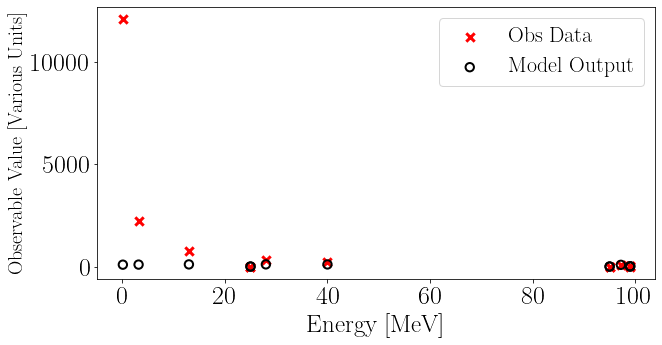

In [11]:
# sanity check of model output (should differ if Lambda != 450)

# LEC test values
C1S0 = -0.112927/100.0
C3S1 = -0.076340/100.0
gA2  = 1.29*1.29;
C3P0 = 1.3e-8;
C3P2 = 0.1e-8;
        
LECs_test = np.array([C1S0,C3S1,C3P0,C3P2]).reshape(-1,1)

model_output_test = np.zeros_like(obs_data_observables)

for i in range(len(variables_observables)):
    model_output_test[i] = cross_section_model(LECs_test, *variables_observables[i])
    
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(energies_observables, obs_data_observables, color='red', marker='x', lw=3, s=70, label='Obs Data')
ax.scatter(energies_observables, model_output_test, lw=2, ec='black', fc='None', s=70, label='Model Output')
ax.legend(loc='best')
ax.set_xlabel('Energy [MeV]', fontsize=25)
ax.set_ylabel('Observable Value [Various Units]',  fontsize=20)

# History Matching - Phase Shifts

In [12]:
# define parameter space to search

C1S0_bound = np.array([-0.3/100.0, 0.0/100.0]).reshape(1,-1)
C3S1_bound = np.array([-1/100.0, 1.0/100.0]).reshape(1,-1)
C3P0_bound = np.array([-1e-7, 2e-7]).reshape(1,-1)
C3P2_bound = np.array([-1e-7, 1e-7]).reshape(1,-1)

parameter_bounds = np.concatenate((C1S0_bound, C3S1_bound, \
                                   C3P0_bound, C3P2_bound), axis=0)


In [13]:
volshapes = ['gaussian', 'hypercube', 'hypercube_rot', 'ellipsoid']

In [14]:
nwaves = 1
ndim = 4
nsamples = 1 * (10**4)
volshape = 'hypercube'

In [15]:
# initialise history matching class
HM = historymatch.HistoryMatch(ndim, filename='result_dict', emulator='GP', volume_shape=volshape)
# initialise results class
Results = historymatch.Results('resultfile')

In [16]:
# set model to generate phase shifts
ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(phase_shift_model_1dimensional)

In [17]:
results_1D_NI = []
results_1D_samples = []

In [18]:
# parameters are independent of each other, so run 4 1D history matches to construct new parameter ranges

HM.initialize_volume(parameter_bounds[0,0], parameter_bounds[0,1])

wave_C1S0 = HM.run_wave(1, obs_data_ps[0:6], sigma_obs_ps[0:6], sigma_model_ps[0:6], \
                       sigma_method_ps[0:6], variables_ps_C1S0[0:6], nsamples=nsamples, \
                       ntraining=3, Imax1=None, Imax2=3, Imax3=None, ndim=1)

#HM.store_result(Results, wave=1, wave_results = wave_C1S0)

results_1D_NI.append(wave_C1S0[0])
results_1D_samples.append(wave_C1S0[1])

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.23s/it]

{0.0: 2155, 3.0: 1, 4.0: 7457}
Number of Non-Implausible Samples: 1931


In [19]:
HM.initialize_volume(parameter_bounds[1,0], parameter_bounds[1,1])

wave_C3S1 = HM.run_wave(1, obs_data_ps[6:12], sigma_obs_ps[6:12], sigma_model_ps[6:12], \
                       sigma_method_ps[6:12], variables_ps_C3S1[6:12], nsamples=nsamples, \
                       ntraining=3, Imax1=None, Imax2=3, Imax3=None, ndim=1)

#HM.store_result(Results, wave=2, wave_results = wave_C3S1)
results_1D_NI.append(wave_C3S1[0])
results_1D_samples.append(wave_C3S1[1])

100%|█████████████████████████████████████████████| 6/6 [01:04<00:00, 10.67s/it]

{0.0: 6602, 1.0: 956, 2.0: 526, 4.0: 621}
Number of Non-Implausible Samples: 1887


In [20]:
HM.initialize_volume(parameter_bounds[2,0], parameter_bounds[2,1])

wave_C3P0 = HM.run_wave(1, obs_data_ps[12:18], sigma_obs_ps[12:18], sigma_model_ps[12:18], \
                       sigma_method_ps[12:18], variables_ps_C3P0[12:18], nsamples=nsamples, \
                       ntraining=3, Imax1=None, Imax2=3, Imax3=None, ndim=1)

#HM.store_result(Results, wave=3, wave_results = wave_C3P0)

results_1D_NI.append(wave_C3P0[0])
results_1D_samples.append(wave_C3P0[1])

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.23s/it]

{0.0: 5, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 9978}
Number of Non-Implausible Samples: 24


In [21]:
HM.initialize_volume(parameter_bounds[3,0], parameter_bounds[3,1])

wave_C3P2 = HM.run_wave(1, obs_data_ps[18:24], sigma_obs_ps[18:24], sigma_model_ps[18:24], \
                       sigma_method_ps[18:24], variables_ps_C3P2[18:24], nsamples=nsamples, \
                       ntraining=3, Imax1=None, Imax2=3, Imax3=None,  ndim=1)

#HM.store_result(Results, wave=4, wave_results = wave_C3P2)

results_1D_NI.append(wave_C3P2[0])
results_1D_samples.append(wave_C3P2[1])

100%|█████████████████████████████████████████████| 6/6 [01:03<00:00, 10.63s/it]

{0.0: 1}
Number of Non-Implausible Samples: 9999


In [22]:
for wave in range(4):
    file = open("data_ladder/phase_shift_1D_nonimp_{}_im2.txt".format(wave+1), "w")
    np.savetxt(file, results_1D_NI[wave])
    file.close()
    file2 = open("data_ladder/phase_shift_1D_samples_{}_im2.txt".format(wave+1), "w")
    np.savetxt(file2, results_1D_samples[wave])
    file2.close()

# History Match - Scattering Observables

In [24]:
# reinitialise volume with results from wave 1

parameter_bounds_wave_2 = np.zeros_like(parameter_bounds)

for i in range(4):
    parameter_bounds_wave_2[i] = [np.min(results_1D_NI[i][:,0]), np.max(results_1D_NI[i][:,0])]
    
HM.initialize_volume(parameter_bounds_wave_2[:,0], parameter_bounds_wave_2[:,1])

In [25]:
# change model to generate scattering observables
ToyModel.set_simulator(cross_section_model)

In [26]:
start = time.time()

results_wave2 = HM.run_wave(1, obs_data_observables, sigma_obs_observables, sigma_model_observables, sigma_method_observables, \
                            variables_observables, nsamples= (1*10**5), Imax1=3, Imax2=2.5, Imax3=None)

end = time.time()

100%|██████████████████████████████████████████| 13/13 [40:53<00:00, 188.74s/it]

10297
8088
{0.0: 16512, 7.0: 1201, 9.0: 55185, 10.0: 16805}
Number of Non-Implausible Samples: 8088


In [27]:
print('Time for wave : ' + str(end - start) + ' s')
print('Time for wave : ' + str((end - start)/3600) + ' hours')

Time for wave : 2453.6867961883545 s
Time for wave : 0.6815796656078762 hours


In [28]:
HM.store_result(Results, wave=1, wave_results = results_wave2)

volume fraction (hypercube) : 0.008319324854798261


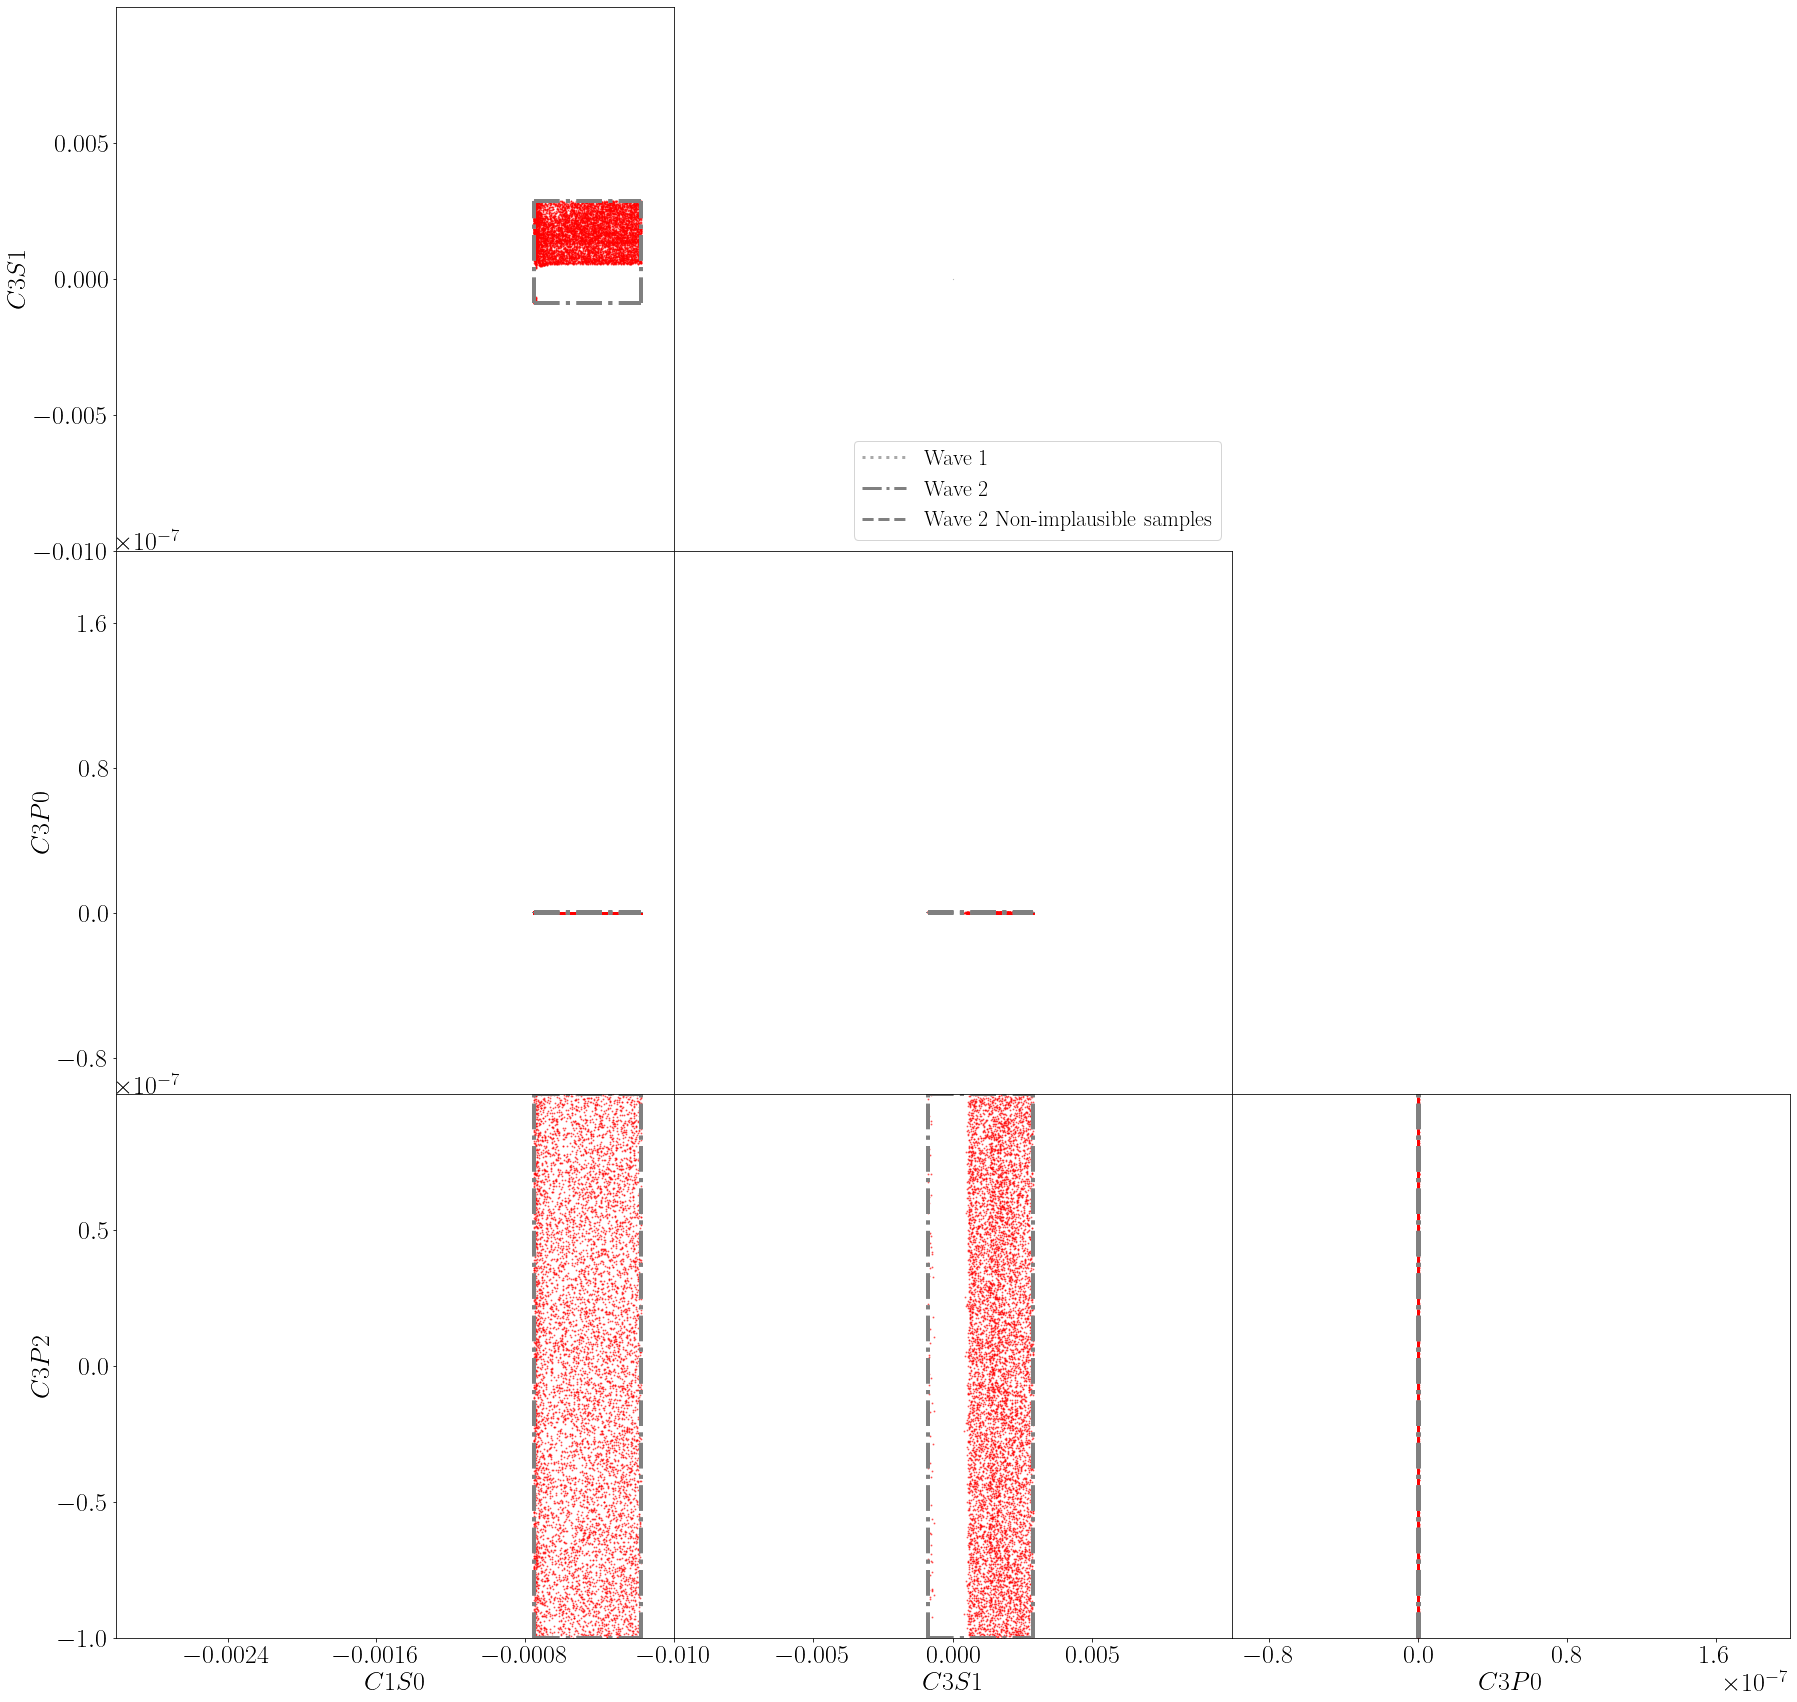

In [46]:
# plot corner plot of hypercube wave progression


colors = ['darkgrey', 'grey', 'grey', 'black', 'red']
linestyles = [':', '-.', '--','-','-','-', '-']
theta_names = [r'$C1S0$', r'$C3S1$', r'$C3P0$', r'$C3P2$']
dec_list = [1,1,1,0,0,0]

fig, axes = plt.subplots(ndim-1, ndim-1, figsize=(30,30))

for k in range(1,2):
    
    dims = ndim
        
    # compute bounds of HC nonimplausible samples
    bounds_hypercube = utils.locate_boundaries(Results.nonimplausible[k-1], dims)
    
    # compute volume of hypercube
    volume = 1
    initial_volume = 1
    for i in range(dims):
        volume *= np.abs(bounds_hypercube[i,1]-bounds_hypercube[i,0])
        initial_volume *= np.abs(parameter_bounds[i,1]-parameter_bounds[i,0])
    print('volume fraction (hypercube) : ' + str(100*volume/initial_volume))

        
    # plot hypercubes for each dimension
    for i in range(dims-1):
        for j in range(dims):
            ax = axes[j-1,i]
                
            if i < j:
                
                if i != 0:
                    None
                    ax.axes.yaxis.set_visible(False)
                else:
                    ax.set_ylabel(theta_names[j])
                    
                if j == 3:
                    ax.set_xlabel(theta_names[i])
                else:
                    None

                if k==1:
                    ax.scatter(Results.nonimplausible[k-1][:,i], Results.nonimplausible[k-1][:,j], alpha=0.5, s=1, color='red')
                
                # plot wave 2 hypercube
                if k == 1:
                    ax.plot([parameter_bounds_wave_2[i,0], parameter_bounds_wave_2[i,1]], [parameter_bounds_wave_2[j,0], parameter_bounds_wave_2[j,0]], color=colors[k-1], linestyle=linestyles[k-1], linewidth=4)
                    ax.plot([parameter_bounds_wave_2[i,0], parameter_bounds_wave_2[i,1]], [parameter_bounds_wave_2[j,1], parameter_bounds_wave_2[j,1]], color=colors[k-1], linestyle=linestyles[k-1], linewidth=4)
                
                    ax.plot([parameter_bounds_wave_2[i,0], parameter_bounds_wave_2[i,0]], [parameter_bounds_wave_2[j,0], parameter_bounds_wave_2[j,1]], color=colors[k-1], linestyle=linestyles[k-1], linewidth=4)
                    ax.plot([parameter_bounds_wave_2[i,1], parameter_bounds_wave_2[i,1]], [parameter_bounds_wave_2[j,0], parameter_bounds_wave_2[j,1]], color=colors[k-1], linestyle=linestyles[k-1], linewidth=4)
                    
                # plot wave 1 hypercube
                ax.plot([bounds_hypercube[i,0], bounds_hypercube[i,1]], [bounds_hypercube[j,0], bounds_hypercube[j,0]], color=colors[k], linestyle=linestyles[k], linewidth=4)
                ax.plot([bounds_hypercube[i,0], bounds_hypercube[i,1]], [bounds_hypercube[j,1], bounds_hypercube[j,1]], color=colors[k], linestyle=linestyles[k], linewidth=4)
                
                ax.plot([bounds_hypercube[i,0], bounds_hypercube[i,0]], [bounds_hypercube[j,0], bounds_hypercube[j,1]], color=colors[k], linestyle=linestyles[k], linewidth=4)
                ax.plot([bounds_hypercube[i,1], bounds_hypercube[i,1]], [bounds_hypercube[j,0], bounds_hypercube[j,1]], color=colors[k], linestyle=linestyles[k], linewidth=4)
                
                
                # set limits to correspond to starting range & fix ticks
                ax.set_xlim([parameter_bounds_wave_2[i,0],parameter_bounds_wave_2[i,1]])
                ax.set_ylim([parameter_bounds_wave_2[j,0],parameter_bounds_wave_2[j,1]])
                ax.set_xticks(np.linspace(parameter_bounds[i,0], parameter_bounds[i,1], 4))
                ax.set_yticks(np.linspace(parameter_bounds[j,0], parameter_bounds[j,1], 4))
                ax.yaxis.set_major_locator(MaxNLocator(nbins=4,prune='upper'))
                ax.xaxis.set_major_locator(MaxNLocator(nbins=4,prune='upper'))
                
            elif i == j:
                if i == 1:
                    # add legend
                    pts = ax.scatter(0,0,color='black', s=0.01)
                    lines = [Line2D([0], [0], color=colors[c], linewidth=3, linestyle=linestyles[c]) for c in range(len(colors))]
                    lines.append(pts)
                    labels = ['Wave 1', 'Wave 2', 'Wave 2 Non-implausible samples']
                    ax.legend(lines, labels, loc='lower right')
                    ax.set_zorder(1)
                    ax.axis('off') 
    
            elif i==3:
                ax.axis('off')
            elif i==2 and j==1:
                None
                ax.axis('off')

axes[1,2].axis('off')

fig.subplots_adjust(wspace=0, hspace=0)


# Save Results

In [32]:
# save data to file

for wave in range(1):
    file = open("data_ladder/observables_nonimp_{}_IMAX2_{}_im2.txt".format(wave+1,cutoff), "w")
    np.savetxt(file, Results.nonimplausible[wave])
    file.close()
    file2 = open("data_ladder/observables_samples_{}_IMAX2_{}_im2.txt".format(wave+1,cutoff), "w")
    np.savetxt(file2, Results.samples_I[wave])
    file2.close()

In [33]:
# save data to file

dataset = pd.DataFrame({'C1SO': Results.nonimplausible[0][:, 0], 'C3S1': Results.nonimplausible[0][:, 1], 'C3P0': Results.nonimplausible[0][:, 2],'C3P2': Results.nonimplausible[0][:, 3], 'IM2': Results.nonimplausible[0][:, 4]})
dataset.to_csv('data_ladder/nonimplausible_samples_{}_im2.csv'.format(cutoff), index=False)

dataset_samples = pd.DataFrame({'C1SO': Results.samples_I[0][:, 0], 'C3S1': Results.samples_I[0][:, 1], 'C3P0': Results.samples_I[0][:, 2],'C3P2': Results.samples_I[0][:, 3], 'IM2': Results.samples_I[0][:, 4]})
dataset_samples.to_csv('data_ladder/all_samples_{}_im2.csv'.format(cutoff), index=False)

"\ndataset = pd.DataFrame({'C1SO': Results.nonimplausible[1][:, 0], 'C3S1': Results.nonimplausible[1][:, 1], 'C3P0': Results.nonimplausible[1][:, 2],'C3P2': Results.nonimplausible[1][:, 3], 'IM2': Results.nonimplausible[1][:, 4]})\ndataset.to_csv('data_ladder/nonimplausible_samples_{}_im2_large.csv'.format(cutoff), index=False)\n\ndataset_samples = pd.DataFrame({'C1SO': Results.samples_I[1][:, 0], 'C3S1': Results.samples_I[1][:, 1], 'C3P0': Results.samples_I[1][:, 2],'C3P2': Results.samples_I[1][:, 3], 'IM2': Results.samples_I[1][:, 4]})\ndataset_samples.to_csv('data_ladder/all_samples_{}_im2_large.csv'.format(cutoff), index=False)"